<h1>E-commerce via Computer Vision</h1>

## Raw Scrape of globalindustrial.com - 5th Step (Some Data Exploration & Persist Results)

In [21]:
# ENVIRONMENT VARIABLES
PROJECT = 'hidden-layers-llc'
REGION  = 'us-east1'
BUCKET  = 'hidden-layers-llc'
MODULE = 'ai'
COMPONENT = 'images-raw'
GS = 'gs://'

In [22]:
%%bash
gcloud config set project hidden-layers-llc
gcloud config set compute/region us-east1

Updated property [core/project].
Updated property [compute/region].


In [4]:
# ONLY UNCOMMENT AND RUN THE BELOW SHELL SCRIPT IF NEEDED (IF THIS NOTEBOOK IS THE 1ST OPENED FOR THIS SESSION)
#!bash install_scrape_libs.sh

In [23]:
# import necessary libraries
import time
import os
import csv
from PIL import Image
from copy import deepcopy
import cv2
import numpy as np
import pandas as pd
from io import BytesIO
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle as pkl
import operator
from collections import OrderedDict
from orderedset import OrderedSet
import random
from shutil import copy2

In [30]:
# GLOBAL VARIABLES FOR THIS SITE
# create search combinations
cats = ['Adjustable Wrenches', 'Adjustable Wrench Set']  #NOTICE THE CORRECT BRANDS, INCL. RIDGID
brands = ['Stanley', 'IRWIN Tools', 'Urrea', 'Proto', 'RIDGID', 'Facom', 'Klein Tools']
search_entries = [brand+' '+cat for brand in brands for cat in cats] # list of normal-Engligh search terms
# known (from Chrome inspection) pre-product-specific page URL path
paths_ok = ['https://www.globalindustrial.com/p/tools/Ratchets-Sockets/Wrenches-Adjustable',
            'https://www.globalindustrial.com/p/tools/Ratchets-Sockets/Wrenches-Adjustable/Adjustable-Wrenches',
            'https://www.globalindustrial.com/p/tools/Ratchets-Sockets/Wrenches-Adjustable/adjustable-wrench-sets']
# desired data field for each image
desired_fields = ['img_no', 'manufacturer', 'description', 'retailer_sku', 'manufacturer_sku', 'img_url', 'img_name']
# set the base_url
base_url = 'https://www.globalindustrial.com'
# create the initials/abbreviation to identify the site
site_initials = 'GIC'
# set the current directory in which this notebook resides
curr_dir = os.getcwd()

In [31]:
print('hello world')

hello world


In [26]:
# retrieve the data from Step 4
with open('df_pages_CLEAN_pkl.pickle', 'rb') as df_GIC:
  df_GIC_clean = pkl.load(df_GIC)

In [32]:
# Let's capture some important metadata for the calculation of distribution by brand
# capture each unique brand and its count in the dataset
brands_list = df_GIC_clean['manufacturer'].tolist()
class_no = len(brands_list)
brands_set = OrderedSet(brands_list)
brands_set_list = list(brands_set)
brand_counts = [brands_list.count(brand) for brand in brands_set_list]
# capture the brand indices in the DataFrame by brand
brands_indices = []
curr_idx = 0
for brand, brand_count in zip(brands, brand_counts):
  brand_indices = []
  for i in range(brand_count):
    brand_indices.append(i + curr_idx)
  brands_indices.append(brand_indices)
  curr_idx += brand_count
# For each brand, capture its count (frequency) and its indices in the dataset
brand_dict = OrderedDict()
for brand_no, brand in enumerate(brands):
    brand_dict[brand] = [brand_counts[brand_no], brands_indices[brand_no]]
print('brand_dict:')
display(brand_dict)
# capture the number of brands
brand_no = len(set(brands))

brand_dict:


OrderedDict([('Stanley', [9, [0, 1, 2, 3, 4, 5, 6, 7, 8]]),
             ('IRWIN Tools', [6, [9, 10, 11, 12, 13, 14]]),
             ('Urrea', [2, [15, 16]]),
             ('Proto', [6, [17, 18, 19, 20, 21, 22]]),
             ('RIDGID', [4, [23, 24, 25, 26]]),
             ('Facom', [1, [27]]),
             ('Klein Tools', [1, [28]])])

In [33]:
# Now, let's summarize for the distribution by brand & create a visualization
brand_count_dict = {brand : cnt for brand, cnt in zip(brands, brand_counts)}
brand_count_dict = sorted(brand_count_dict.items(), key=operator.itemgetter(1))
brand_count_dict = OrderedDict(brand_count_dict)
brand_count_dict = OrderedDict(reversed(list(brand_count_dict.items())))

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


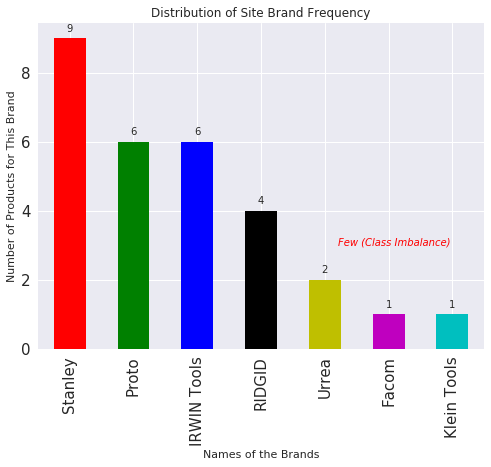

In [34]:
# Plot the data distribution
plt.clf()
# Based upon http://pandas.pydata.org/pandas-docs/version/0.13.1/visualization.html
my_colors = 'rgbkymc'
df2 = pd.DataFrame([int(y) for y in brand_count_dict.values()], [x for x in brand_count_dict.keys()])
plt.figure()
ax = df2.plot(kind='bar', figsize=(8,6), \
              title='Distribution of Site Brand Frequency', \
              grid=True, stacked=True, color=my_colors, sort_columns=False, legend=False, fontsize=15);
ax.set_xlabel("Names of the Brands")
ax.set_ylabel("Number of Products for This Brand")
# From https://stackoverflow.com/questions/25447700/annotate-bars-with-values-on-pandas-bar-plots
for p in ax.patches: 
    ax.annotate(np.round(p.get_height(),decimals=0).astype(int), (p.get_x()+p.get_width()/2.0, 
        p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
ax.text(float(4.2),float(3.0),"Few (Class Imbalance)", style='italic', fontsize=10, color='r')
plt.savefig('brand_GIC_distribution.png')

In [36]:
# Let's pick a few images to view
img_indices = []
img_tags = []
img_names = []
class_no = df_GIC_clean['img_no'].size
brand_no = len(brand_count_dict)
sample_cnt = 9 # THREE for Stanley (highest cardinality & images appear homogoneous). ONE for each other brand. 
for brand, values in brand_dict.items():
  brand_values = brand_dict[brand]
  brand_idxs = brand_values[1]
  if len(brand_idxs) > 6:
    brand_indices = np.random.choice(brand_idxs, 3, replace=False).tolist()
    for idx in brand_indices:
      img_indices.append(idx)
      img_tags.append(brand)  
  elif len(brand_idxs) >= 2 and len(brand_idxs) <= 6:
    brand_index = np.random.choice(brand_idxs, 1, replace=False).tolist()[0]
    img_indices.append(brand_index)
    img_tags.append(brand)
  else:
    img_indices.append(brand_idxs[0])
    img_tags.append(brand)

for idx in img_indices:
  img_name = df_GIC_clean.ix[idx, 'img_name']
  img_names.append(img_name)

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


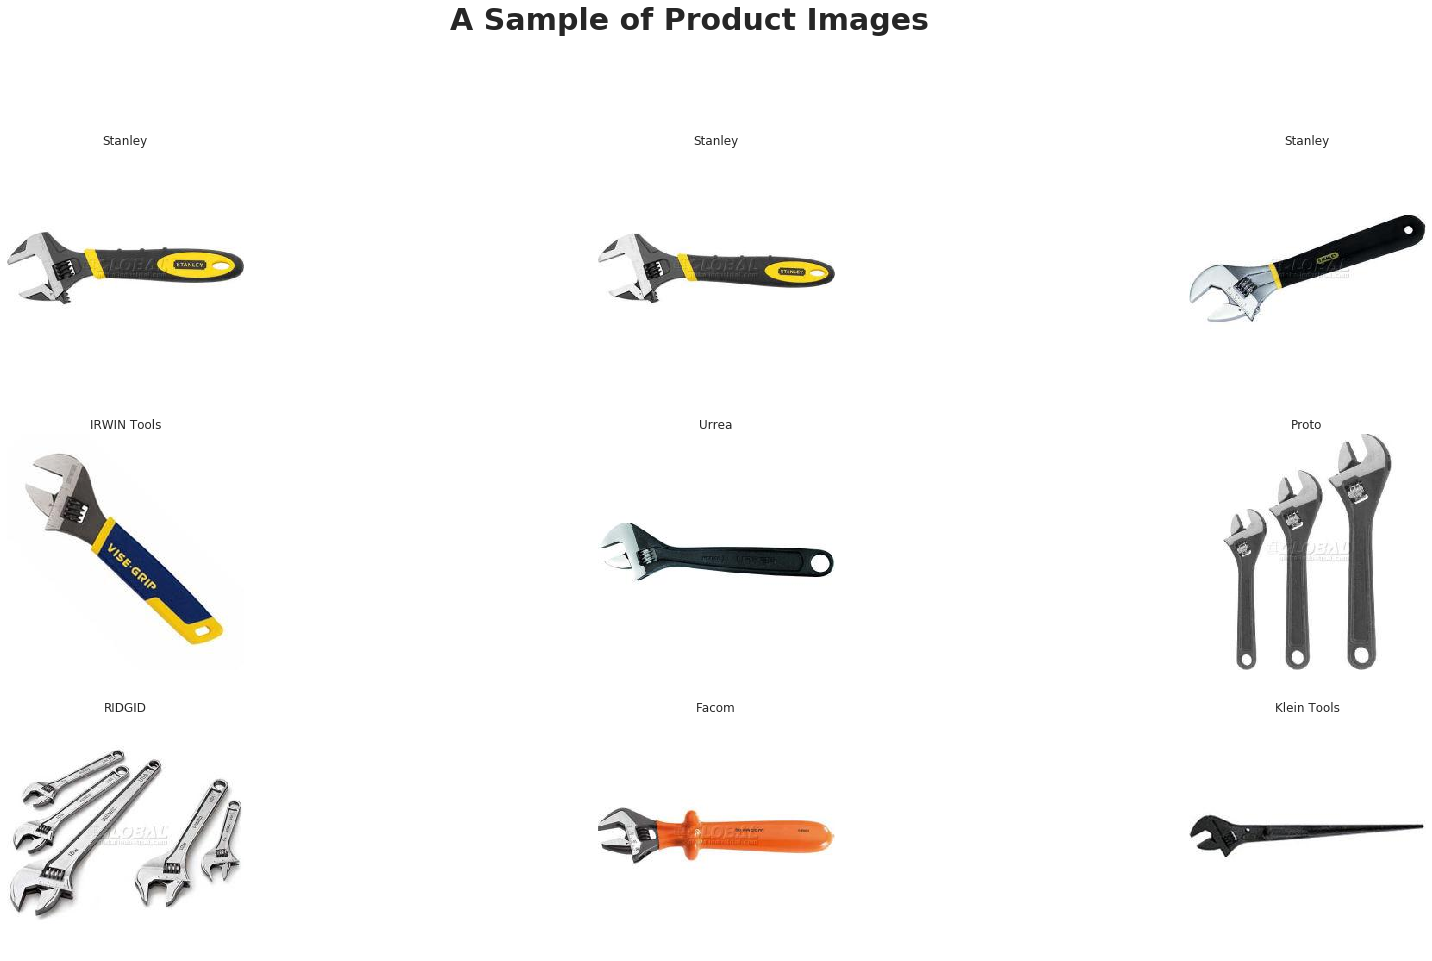

In [38]:
# Now, let's view those images
#plt.clf()  # No need to call this now, as last plot didn't call .show()
images_sample = []

for img_name in img_names:
  img=cv2.imread(img_name) # Use cv2.imread, which doesn't change color scheme
  img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Site's images in BGR
  images_sample.append(img)

plt.figure(figsize=(30,20))
plt.suptitle('A Sample of Product Images', fontsize=30, weight='bold')
for i in range(sample_cnt):
    plt.subplot(431 + i)
    plt.title(img_tags[i])
    plt.xticks([])
    plt.yticks([])   
    plt.imshow(images_sample[i])

plt.show()
plt.savefig('site_images_sample.png')

In [39]:
# Let's check some metadata for each sampled image to know what we have
for img_no, image in enumerate(images_sample):
  print('for img_no: {} the shape is: {}'.format(img_no, image.shape))
  print('for img_no: {} the type is: {}'.format(img_no, type(image)))

for img_no: 0 the shape is: (275, 275, 3)
for img_no: 0 the type is: <class 'numpy.ndarray'>
for img_no: 1 the shape is: (275, 275, 3)
for img_no: 1 the type is: <class 'numpy.ndarray'>
for img_no: 2 the shape is: (275, 275, 3)
for img_no: 2 the type is: <class 'numpy.ndarray'>
for img_no: 3 the shape is: (275, 275, 3)
for img_no: 3 the type is: <class 'numpy.ndarray'>
for img_no: 4 the shape is: (275, 275, 3)
for img_no: 4 the type is: <class 'numpy.ndarray'>
for img_no: 5 the shape is: (275, 275, 3)
for img_no: 5 the type is: <class 'numpy.ndarray'>
for img_no: 6 the shape is: (275, 275, 3)
for img_no: 6 the type is: <class 'numpy.ndarray'>
for img_no: 7 the shape is: (275, 275, 3)
for img_no: 7 the type is: <class 'numpy.ndarray'>
for img_no: 8 the shape is: (275, 275, 3)
for img_no: 8 the type is: <class 'numpy.ndarray'>


In [40]:
# Let's create the common, requisite Computer Vision directories for each of the classes
home_dir = deepcopy(os.path.expanduser('~'))
current_folder = deepcopy(os.getcwd())
os.chdir('..') # IMPORTANT: THIS FOLDER HAS BEEN CREATED AS A SUB-DIR OF THE PROJECT FOLDER
project_folder = deepcopy(os.getcwd())
os.chdir(current_folder)
current_dir_contents = os.listdir(current_folder)
img_fids = [fid for fid in current_dir_contents if fid.endswith('.jpg')]
images_subdir = 'images'
train_subdir = 'train'
validation_subdir = 'validation'
test_subdir = 'test'
if not os.path.isdir(os.path.join('..', images_subdir)):
  os.mkdir(os.path.join('..',images_subdir))
  if not os.path.isdir(os.path.join('..', images_subdir, train_subdir)):
    os.mkdir(os.path.join('..',images_subdir, train_subdir))
  if not os.path.isdir(os.path.join('..', images_subdir, validation_subdir)):
    os.mkdir(os.path.join('..',images_subdir, validation_subdir))
  if not os.path.isdir(os.path.join('..', images_subdir, test_subdir)):
    os.mkdir(os.path.join('..',images_subdir, test_subdir))
    
classes = [fid.split('.')[0] for fid in img_fids]

for mode in [train_subdir, validation_subdir, test_subdir]:
  for pic_class in classes:
    if not os.path.isdir(os.path.join('..',images_subdir, mode, pic_class)):
      os.mkdir(os.path.join('..',images_subdir, mode, pic_class))

In [41]:
# Now let's copy the images to the test image subdirectory
mode = test_subdir
for pic_class, fid in zip(classes, img_fids):
  copy2(fid, os.path.join('..', images_subdir, mode, pic_class))

In [42]:
# Finally, let's store off data in readily-accessible form for efficient later steps
target_site_folder = current_folder
images_folder = os.path.join(project_folder, images_subdir)
images_train_folder = os.path.join(project_folder, images_subdir, train_subdir)
images_validation_folder = os.path.join(project_folder, images_subdir, validation_subdir)
images_test_folder = os.path.join(project_folder, images_subdir, test_subdir)

with open('dir_paths.pickle', 'wb') as directory_paths:
  pkl.dump(home_dir, directory_paths, protocol=pkl.HIGHEST_PROTOCOL)
  pkl.dump(project_folder, directory_paths, protocol=pkl.HIGHEST_PROTOCOL)
  pkl.dump(target_site_folder, directory_paths, protocol=pkl.HIGHEST_PROTOCOL)
  pkl.dump(images_folder, directory_paths, protocol=pkl.HIGHEST_PROTOCOL)
  pkl.dump(images_train_folder, directory_paths, protocol=pkl.HIGHEST_PROTOCOL)
  pkl.dump(images_validation_folder, directory_paths, protocol=pkl.HIGHEST_PROTOCOL)
  pkl.dump(images_test_folder, directory_paths, protocol=pkl.HIGHEST_PROTOCOL)
  pkl.dump(classes, directory_paths, protocol=pkl.HIGHEST_PROTOCOL)
copy2('dir_paths.pickle','..')

'../dir_paths.pickle'

In [44]:
# Finally, let's copy the images for the project report, as well as this site's summary DataFrame up to the project folder
report_img_fids = [fid for fid in os.listdir(current_folder) if fid.endswith('.png')]
for fid in report_img_fids:
  copy2(fid, '..')
copy2('df_pages_CLEAN_pkl.pickle', '..')

'../df_pages_CLEAN_pkl.pickle'

## NOW we have project-level data and details of the ground truth.  On to scraping for train, validation sets.